In [1]:

from sklearn.metrics import (
    log_loss,
    brier_score_loss,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import train_test_split

from load_data import load_datasets

import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, log_loss, brier_score_loss
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV


In [2]:

all_datasets = load_datasets(["Credit Risk"])
df, target_col = all_datasets['Credit Risk']

In [4]:

def initiate_xgboost(X_train, y_train):
    base_params = {"objective": "binary:logistic", "seed": 42, "n_estimators": 100}
    ModelClass = xgb.XGBClassifier
    scoring = "roc_auc"
    param_distributions = {
        "max_depth": [4, 6, 8],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "subsample": [0.8, 0.9, 1.0],
        "colsample_bytree": [0.8, 0.9, 1.0],
        "alpha": [0, 0.5, 1],
        "lambda": [0, 0.5, 1]
    }
    model = ModelClass(**base_params)
    random_search = RandomizedSearchCV(
        model, param_distributions, n_iter=20, scoring=scoring, cv=3,
        random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

def initiate_logistic_regression(X_train, y_train):
    base_params = {"solver": "liblinear", "random_state": 42, "max_iter": 100}
    ModelClass = LogisticRegression
    scoring = "roc_auc"
    param_distributions = {
        "penalty": ["l1", "l2"],
        "C": np.logspace(-3, 3, 7)
    }
    model = ModelClass(**base_params)
    random_search = RandomizedSearchCV(
        model, param_distributions, n_iter=20, scoring=scoring, cv=3,
        random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

def initiate_random_forest(X_train, y_train):
    base_params = {"n_estimators": 100, "random_state": 42}
    ModelClass = RandomForestClassifier
    scoring = "roc_auc"
    param_distributions = {
        "max_depth": [None, 5, 10, 15],
        "max_features": ["sqrt", "log2", None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False]
    }
    model = ModelClass(**base_params)
    random_search = RandomizedSearchCV(
        model, param_distributions, n_iter=20, scoring=scoring, cv=3,
        random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

def initiate_lightgbm(X_train, y_train):
    base_params = {"objective": "binary", "seed": 42, "n_estimators": 100}
    ModelClass = lgb.LGBMClassifier
    scoring = "roc_auc"
    param_distributions = {
        "max_depth": [4, 6, 8, 10],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "num_leaves": [15, 31, 63],
        "subsample": [0.8, 0.9, 1.0],
        "colsample_bytree": [0.8, 0.9, 1.0],
        "reg_alpha": [0, 0.5, 1],
        "reg_lambda": [0, 0.5, 1]
    }
    model = ModelClass(**base_params)
    random_search = RandomizedSearchCV(
        model, param_distributions, n_iter=20, scoring=scoring, cv=3,
        random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

def initiate_catboost(X_train, y_train):
    base_params = {"loss_function": "Logloss", "random_seed": 42, "iterations": 100, "verbose": 0}
    ModelClass = CatBoostClassifier
    scoring = "roc_auc"
    param_distributions = {
        "depth": [4, 6, 8],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "l2_leaf_reg": [1, 3, 5, 7, 9],
        "border_count": [32, 64, 128]
    }
    model = ModelClass(**base_params)
    random_search = RandomizedSearchCV(
        model, param_distributions, n_iter=20, scoring=scoring, cv=3,
        random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

# --- Evaluation and Saving Functions ---

def evaluate_model(model, X, y):
    # Predict probabilities and class labels
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)
    
    # Calculate evaluation metrics
    auc = roc_auc_score(y, y_pred_proba)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    logloss = log_loss(y, y_pred_proba)
    brier = brier_score_loss(y, y_pred_proba)
    
    return {
        "AUC": auc,
        "Recall": recall,
        "Precision": precision,
        "F1": f1,
        "LogLoss": logloss,
        "Brier": brier
    }

# --- List of Model Initiation Functions ---
model_funcs = {
    "XGBoost": initiate_xgboost,
    "Logistic Regression": initiate_logistic_regression,
    "Random Forest": initiate_random_forest,
    "LightGBM": initiate_lightgbm,
    "CatBoost": initiate_catboost
}

results = []
hyperparams = {}

df1 = df.sample(n=4000, random_state=42)


for model_name, func in model_funcs.items():
    hyperparams[model_name] = {}

    for n_features in range (2, 11):

        X = df1.drop(columns=[target_col]).iloc[:, :n_features]
        y = df1[target_col]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
        
        best_model = func(X_train, y_train)
        
        # Evaluate on train and test
        train_metrics = evaluate_model(best_model, X_train, y_train)
        test_metrics = evaluate_model(best_model, X_test, y_test)
        
        # Collect results
        results.append({
            "Model": model_name,
            "N_Features": n_features,
            "Features": X.columns, 
            "Train AUC": train_metrics["AUC"],
            "Train Recall": train_metrics["Recall"],
            "Train Precision": train_metrics["Precision"],
            "Train F1": train_metrics["F1"],
            "Train LogLoss": train_metrics["LogLoss"],
            "Train Brier": train_metrics["Brier"],
            "Test AUC": test_metrics["AUC"],
            "Test Recall": test_metrics["Recall"],
            "Test Precision": test_metrics["Precision"],
            "Test F1": test_metrics["F1"],
            "Test LogLoss": test_metrics["LogLoss"],
            "Test Brier": test_metrics["Brier"]
        })
        
        # Save hyperparameters
        hyperparams[model_name][str(n_features)] = best_model.get_params()

# Create a DataFrame of results
results_df = pd.DataFrame(results)

# Create directory if it does not exist
output_dir = "baseline_analysis"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the results DataFrame to an Excel file
excel_path = os.path.join(output_dir, "baseline_model_performance.xlsx")
results_df.to_excel(excel_path, index=False)

for model_name, _ in model_funcs.items():

    rows = []
    for key, value in hyperparams[model_name].items():
        value['n_features'] = key
        rows.append(value)

    hyperparams_df = pd.DataFrame(rows)
    hyperparams_df['model'] = model_name
    hyperparams_excel_path = os.path.join(output_dir, f"baseline_{model_name}_hyperparameters.xlsx")
    hyperparams_df.to_excel(hyperparams_excel_path)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 427, number of negative: 1706
[LightGBM] [Info] Number of positive: 427, number of negative: 1706[LightGBM] [Info] Number of positive: 428, number of negative: 1706[LightGBM] [Info] Number of positive: 427, number of negative: 1706
[LightGBM] [Info] Number of positive: 428, number of negative: 1706


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 427, number of negative: 1706
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can 

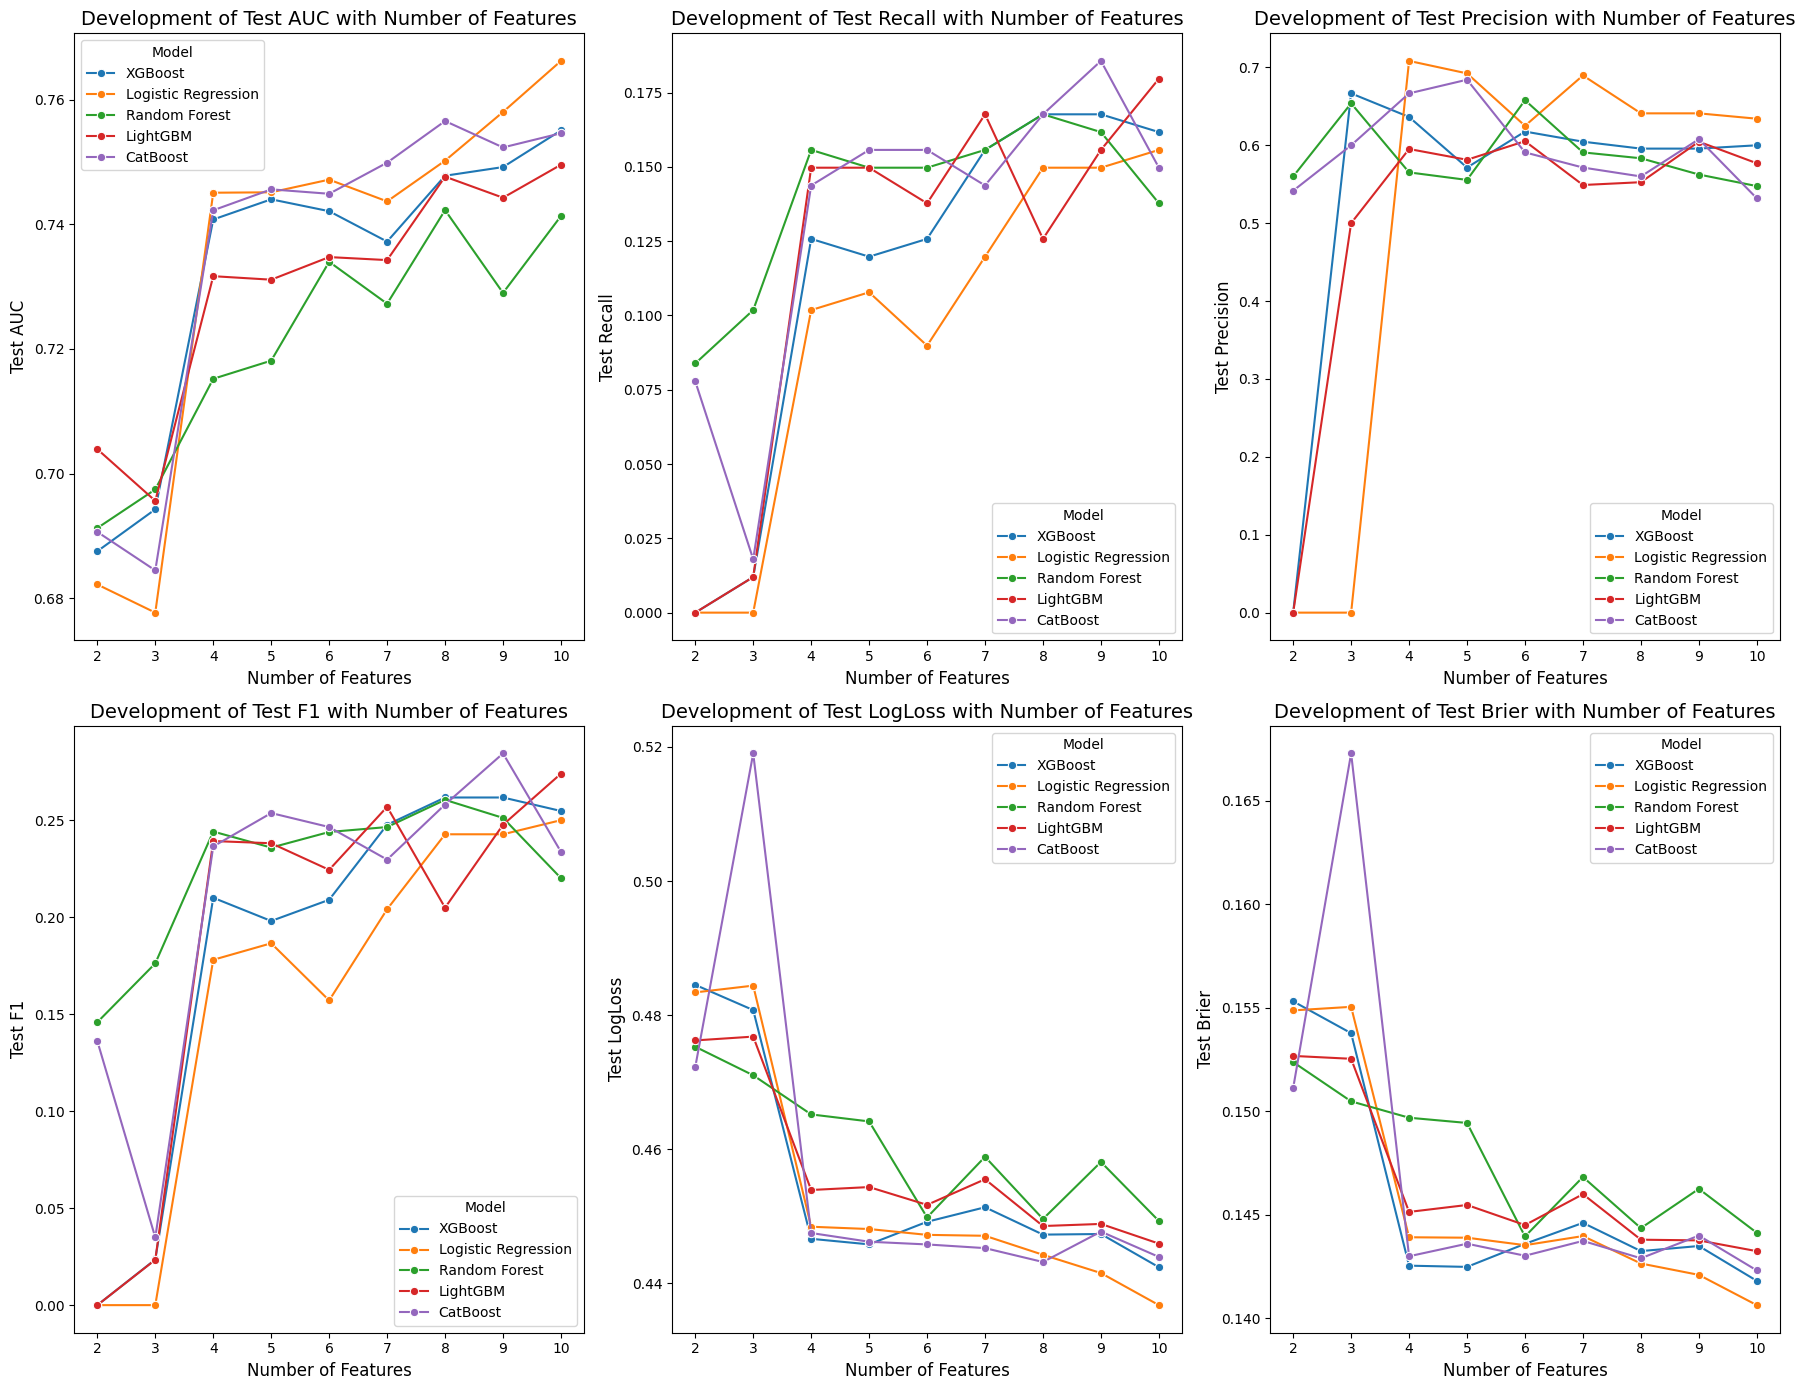

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the baseline performance results from Excel
df_visual = pd.read_excel("baseline_analysis_output/baseline_model_performance.xlsx")

# List the performance metrics to plot
metrics = ['Test AUC', 'Test Recall', 'Test Precision', 'Test F1', 'Test LogLoss', 'Test Brier']

# Set up a multi-panel figure (3 rows x 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 14))
axes = axes.flatten()

# For each metric, create a line plot showing its trend with increasing number of features
for i, metric in enumerate(metrics):
    sns.lineplot(
        data=df_visual,
        x='N_Features',       # column containing number of features used
        y=metric,           # performance metric value
        hue='Model',        # baseline model identifier
        marker='o',
        ax=axes[i]
    )
    axes[i].set_title(f'Development of {metric} with Number of Features', fontsize=14)
    axes[i].set_xlabel('Number of Features', fontsize=12)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].legend(title='Model', loc='best')

plt.tight_layout()
plt.show()


In [13]:

results = []
hyperparams = {}


for model_name, func in model_funcs.items():
    hyperparams[model_name] = {}

    for n_samples in range(1000, 7501, 500):

        df2 = df.sample(n=min(n_samples, df.shape[0]), random_state=42)

        X = df2.drop(columns=[target_col]).iloc[:, :n_features]
        y = df2[target_col]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
        
        best_model = func(X_train, y_train)
        
        # Evaluate on train and test
        train_metrics = evaluate_model(best_model, X_train, y_train)
        test_metrics = evaluate_model(best_model, X_test, y_test)
        
        # Collect results
        results.append({
            "Model": model_name,
            "N_Observations": X.shape[0], 
            "N_Features": X.shape[1],
            "Features": X.columns, 
            "Train AUC": train_metrics["AUC"],
            "Train Recall": train_metrics["Recall"],
            "Train Precision": train_metrics["Precision"],
            "Train F1": train_metrics["F1"],
            "Train LogLoss": train_metrics["LogLoss"],
            "Train Brier": train_metrics["Brier"],
            "Test AUC": test_metrics["AUC"],
            "Test Recall": test_metrics["Recall"],
            "Test Precision": test_metrics["Precision"],
            "Test F1": test_metrics["F1"],
            "Test LogLoss": test_metrics["LogLoss"],
            "Test Brier": test_metrics["Brier"]
        })
        
        # Save hyperparameters
        hyperparams[model_name][str(n_features)] = best_model.get_params()

# Create a DataFrame of results
results_df = pd.DataFrame(results)

# Create directory if it does not exist
output_dir = "baseline_analysis_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the results DataFrame to an Excel file
excel_path = os.path.join(output_dir, "baseline_model_performance2.xlsx")
results_df.to_excel(excel_path, index=False)

for model_name, _ in model_funcs.items():

    rows = []
    for key, value in hyperparams[model_name].items():
        value['n_features'] = key
        rows.append(value)

    hyperparams_df = pd.DataFrame(rows)
    hyperparams_df['model'] = model_name
    hyperparams_excel_path = os.path.join(output_dir, f"baseline_{model_name}_hyperparameters2.xlsx")
    hyperparams_df.to_excel(hyperparams_excel_path)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94, number of negative: 439
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94, number of negative: 439
[LightGBM] [Info] Number of positive: 94, number of negative: 440
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 533, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176360 -> initscore=-1.541205
[LightGBM] [Info] Start training from score -1.541205
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003346 seconds.
You can set `force_row_wise=true` to re

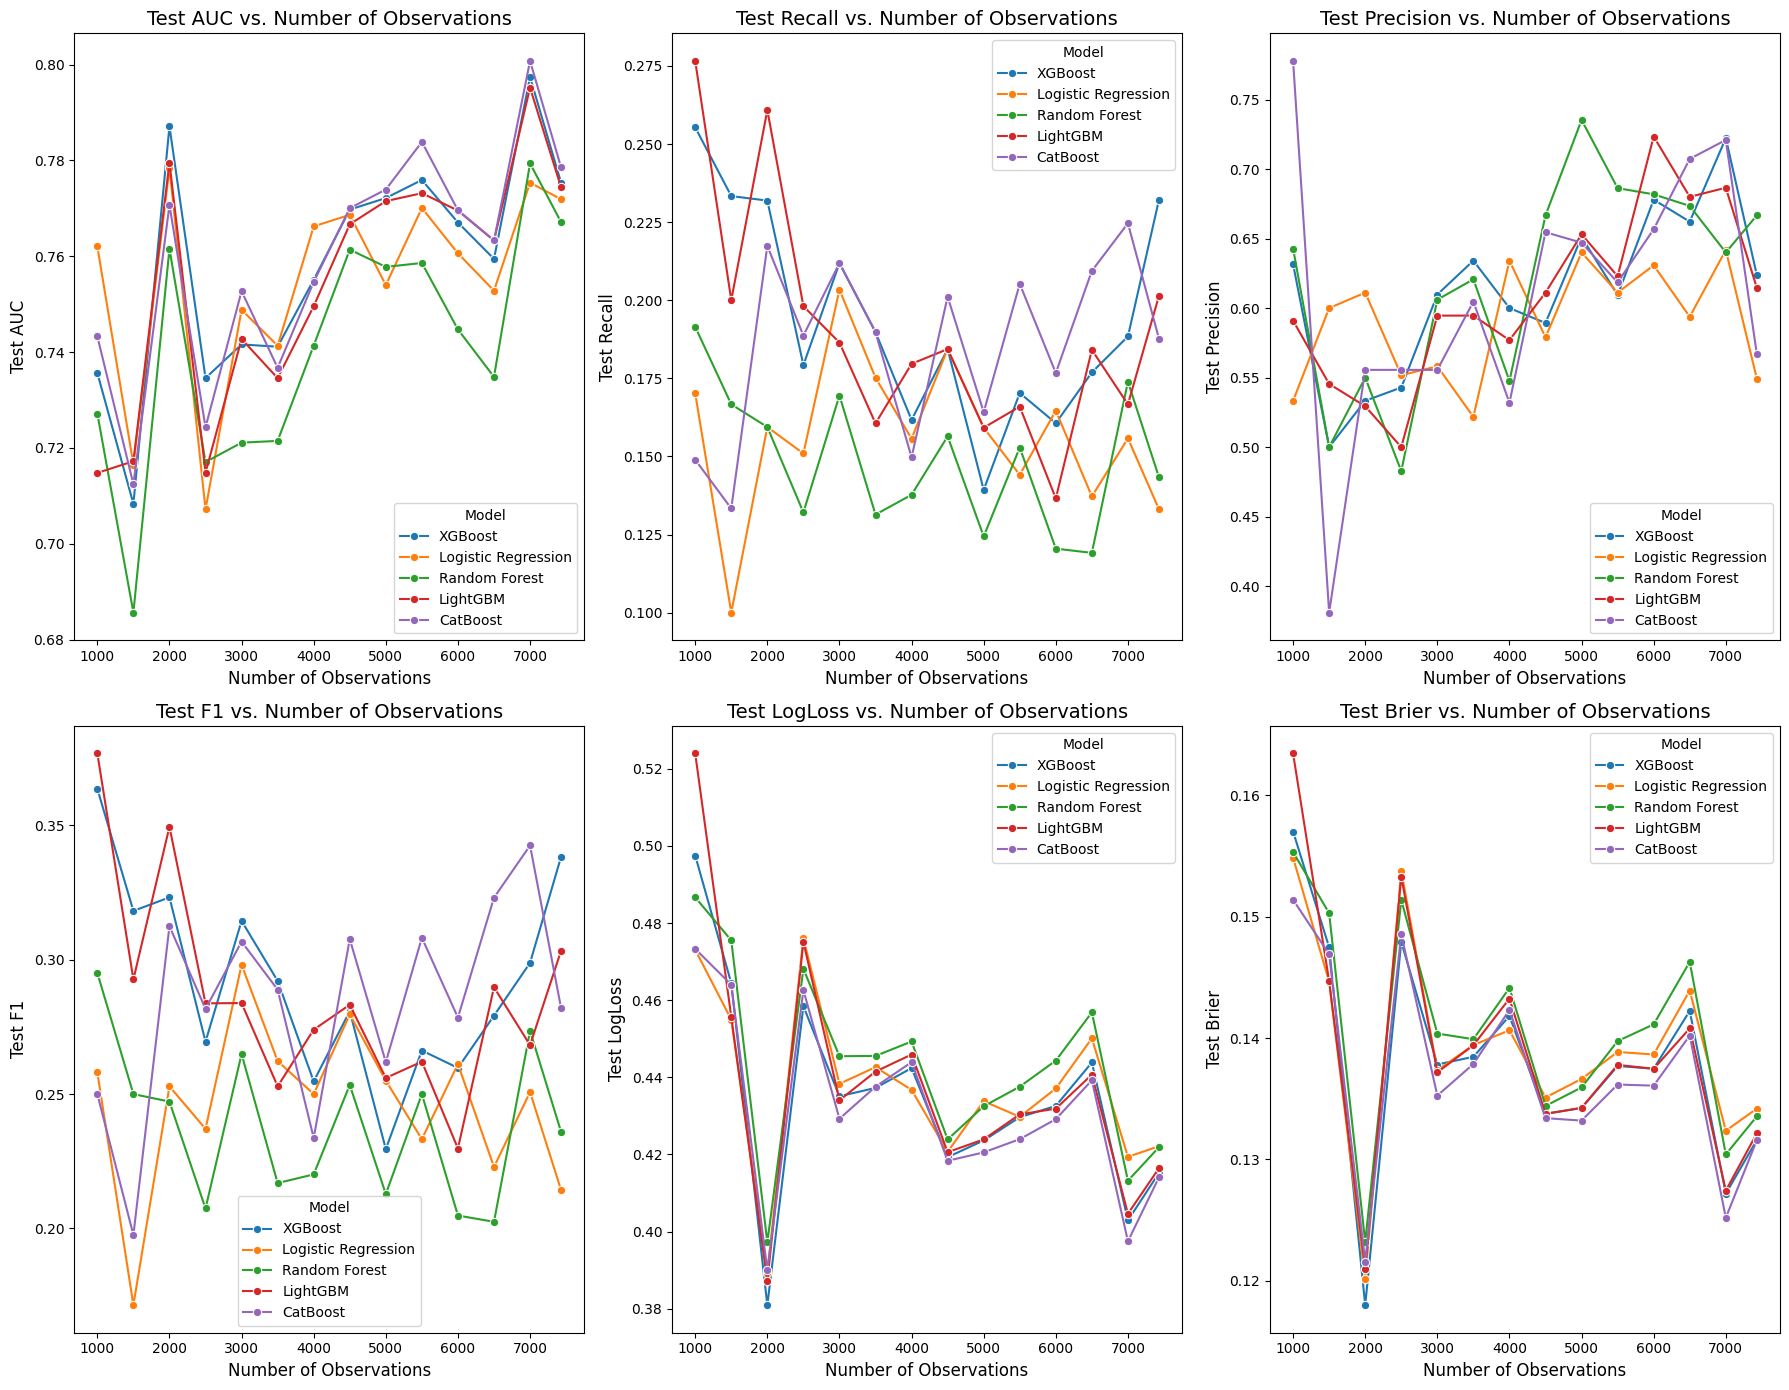

In [3]:


# Read the baseline performance results from Excel.
df_visual = pd.read_excel("baseline_analysis_output/baseline_model_performance2.xlsx")

# Ensure that the DataFrame contains a column 'N_Observations' and a 'Model' column.
# List the performance metrics to plot (e.g., Test AUC, Test Recall, etc.)
metrics = ['Test AUC', 'Test Recall', 'Test Precision', 'Test F1', 'Test LogLoss', 'Test Brier']

# Set up a multi-panel figure (e.g., 3 rows x 2 columns for 6 metrics)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 14))
axes = axes.flatten()

# For each metric, create a line plot showing its trend with increasing number of observations.
for i, metric in enumerate(metrics):
    sns.lineplot(
        data=df_visual,
        x='N_Observations',   
        y=metric,             
        hue='Model',          
        marker='o',
        ax=axes[i]
    )
    axes[i].set_title(f'{metric} vs. Number of Observations', fontsize=14)
    axes[i].set_xlabel('Number of Observations', fontsize=12)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].legend(title='Model', loc='best')

plt.tight_layout()
plt.show()
